In [ ]:
# !kaggle datasets download -d ibrahimfateen/wound-classification

In [ ]:
# !unzip -q wound-classification.zip -d ./dataset/

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 2356 images belonging to 10 classes.
Found 584 images belonging to 10 classes.
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726196175.786811      67 service.cc:145] XLA service 0x7c46d0004090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726196175.786883      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726196273.424574      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.2001 - loss: 2.5811 - val_accuracy: 0.4444 - val_loss: 1.9080 - learning_rate: 1.0000e-04
Epoch 2/25
 1/73 ━━━━━━━━━━━━━━━━━━━━ 26s 373ms/step - accuracy: 0.2812 - loss: 1.8996

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.2812 - loss: 1.8996 - val_accuracy: 0.6250 - val_loss: 1.8655 - learning_rate: 1.0000e-04
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 74s 935ms/step - accuracy: 0.4963 - loss: 1.4942 - val_accuracy: 0.5990 - val_loss: 1.4174 - learning_rate: 1.0000e-04
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.6562 - loss: 0.9958 - val_accuracy: 0.6250 - val_loss: 1.5439 - learning_rate: 1.0000e-04
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 74s 936ms/step - accuracy: 0.6166 - loss: 1.1037 - val_accuracy: 0.6788 - val_loss: 1.0022 - learning_rate: 1.0000e-04
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5312 - loss: 1.3014 - val_accuracy: 0.6250 - val_loss: 0.9530 - learning_rate: 1.0000e-04
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 73s 931ms/step - accuracy: 0.6887 - loss: 0.9077 - val_accuracy: 0.7552 - val_loss: 0.7431 - learning_rate: 1.0000e-04
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.6875 - 

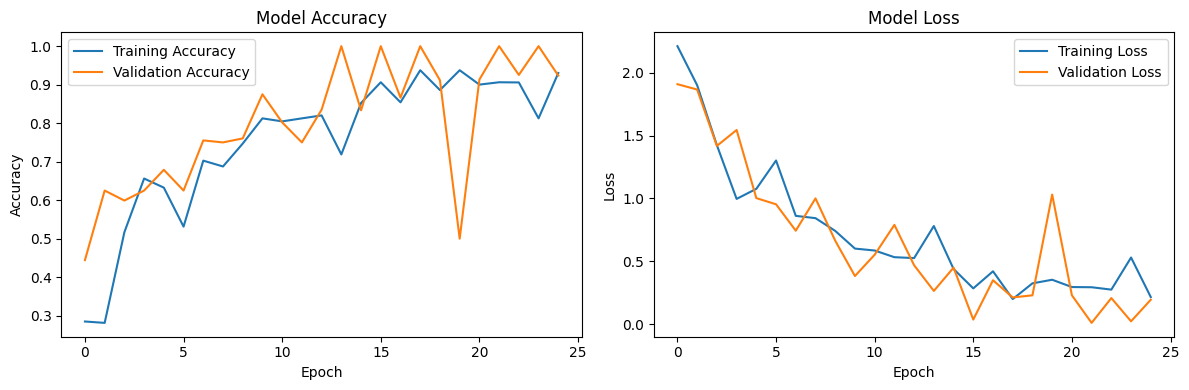

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 724ms/step - accuracy: 0.9231 - loss: 0.2173
Validation accuracy: 0.9127
Validation loss: 0.2414
Training completed. Model saved as 'final_model.keras'
Best model saved as 'best_model.keras'
Training history plot saved as 'training_history.png'


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

# Define hyperparameters
BATCH_SIZE = 32
EPOCHS = 25
IMG_HEIGHT = 300
IMG_WIDTH = 300
INITIAL_LEARNING_RATE = 1e-4

# Set the path to your data directory
DATA_DIR = '/kaggle/input/wound-classification/Wound_dataset copy'

# Get the number of classes from the number of subdirectories
NUM_CLASSES = len([name for name in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, name))])

# Define the base model with pre-trained weights
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Define custom top layers
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = models.Model(inputs, outputs)

# Compile the model with a lower initial learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up data generators with increased augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Set up callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation loss: {val_loss:.4f}")

# Save the final model
model.save('final_model.keras')

print("Training completed. Model saved as 'final_model.keras'")
print("Best model saved as 'best_model.keras'")
print("Training history plot saved as 'training_history.png'")